### Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)
# from google.colab import drive
# drive.mount('/content/drive')

Num GPUs Available: 1
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU enabled for TensorFlow!


In [ ]:
# #unzip Data File
# import zipfile
# with zipfile.ZipFile("/kaggle/input/teethdataset/Teeth_Dataset","r") as zip_ref:
#     zip_ref.extractall("targetdir")

### Load Data Train,Valid,Test

In [2]:
# Define paths
train_path='/kaggle/input/teethdataset/Teeth_Dataset/Training'
valid_path='/kaggle/input/teethdataset/Teeth_Dataset/Validation'
# Define image size and batch size
img_size=(256,256)
batch_size=32
# Load datasets using tf.keras.utils.image_dataset_from_directory
train_dataset=tf.keras.utils.image_dataset_from_directory(train_path,image_size=img_size,batch_size=batch_size,label_mode='categorical')
valid_dataset=tf.keras.utils.image_dataset_from_directory(valid_path,image_size=img_size,batch_size=batch_size,label_mode='categorical')

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


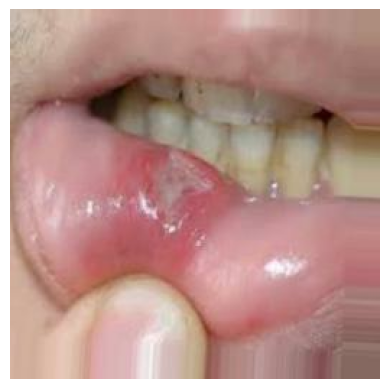

In [6]:
for images, labels in train_dataset.take(1):
    # Plot the first image in the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

### Access Class Names

In [7]:
# Access class names
class_names=train_dataset.class_names
print("Class names:",class_names)

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


### Data Preprocesssing

In [8]:
# Normalize pixel values
normalization_layer=tf.keras.layers.Rescaling(1.0/255.0)
train_dataset_prep=train_dataset.map(lambda x,y:(normalization_layer(x), y))
valid_dataset_prep=valid_dataset.map(lambda x,y:(normalization_layer(x), y))
#test_dataset_prep=test_dataset.map(lambda x,y:(normalization_layer(x), y))
# Cache and prefetch for better performance and use repeat so the model wont run out of data while fitting
train_dataset_prep = train_dataset_prep.cache().prefetch(tf.data.AUTOTUNE).repeat()
valid_dataset_prep = valid_dataset_prep.cache().prefetch(tf.data.AUTOTUNE).repeat()
#test_dataset_prep=test_dataset_prep.cache().prefetch(tf.data.AUTOTUNE).repeat()


### Check Dataset

In [9]:
#Check dataset shapes
for images,labels in train_dataset_prep.take(1):
    print("Train images shape:", images.shape)  # Should be (batch_size, 64, 64, 3)
    print("Train labels shape:", labels.shape)  # Should be (batch_size, num_classes)
for images,labels in valid_dataset_prep.take(1):
    print("Validation images shape:",images.shape)
    print("Validation labels shape:",labels.shape)
# for images, labels in test_dataset_prep.take(1):
#     print("Test images shape:", images.shape)
#     print("Test labels shape:", labels.shape)

Train images shape: (32, 256, 256, 3)
Train labels shape: (32, 7)
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32, 7)


### Make a Simple ConvNet

In [10]:
image_shape=(256,256,3)
simple_cnn=tf.keras.models.Sequential([

tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu',input_shape=image_shape),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(units=128,activation='relu'),
tf.keras.layers.Dense(units=64,activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(units=7,activation='softmax')

])

### Model Summary

In [11]:
simple_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 252, 252, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      29,491,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,874,183 (113.96 MB)

 Trainable params: 29,874,055 (113.96 MB)

 Non-trainable params: 128 (512.00 B)

### Compile The Model

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
simple_cnn.compile(optimizer=optimizer
                   ,loss='categorical_crossentropy'
                   ,metrics=['accuracy']
                   )

In [13]:
batch_size=32
# Calculate steps per epoch
import math
steps_per_epoch=math.ceil(len(train_dataset))
validation_steps=math.ceil(len(valid_dataset))
model_history=simple_cnn.fit(train_dataset_prep,
                         validation_data=valid_dataset_prep,
                         epochs=20,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.2291 - loss: 1.9384 - val_accuracy: 0.1449 - val_loss: 5.1915
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.2961 - loss: 1.7924 - val_accuracy: 0.1109 - val_loss: 2.7939
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3671 - loss: 1.6599 - val_accuracy: 0.2296 - val_loss: 2.3483
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.4499 - loss: 1.4655 - val_accuracy: 0.2792 - val_loss: 1.9547
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5120 - loss: 1.3122 - val_accuracy: 0.3677 - val_loss: 2.0548
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6565 - loss: 0.9746 - val_accuracy: 0.3881 - val_loss: 2.2968
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7737 - loss: 0.6425 - val_accuracy: 0.3492 - val_loss: 3.6712
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8327 - loss: 0.4707 - val_accuracy: 0.3385 -

In [15]:
from tensorflow.keras import layers
def improved_cnn(image_shape=(256, 256, 3), num_classes=7):
    model = tf.keras.models.Sequential([
        
        # First Convolutional Block
        layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=image_shape, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Global Average Pooling (instead of Flattening)
        layers.GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.3),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and summarize the model
model = improved_cnn(image_shape=(256, 256, 3), num_classes=7)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 252, 252, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 252, 252, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 124, 124, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 60, 60, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,287 (1.59 MB)

 Trainable params: 416,391 (1.59 MB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer
                   ,loss='categorical_crossentropy'
                   ,metrics=['accuracy']
                   )


In [22]:
batch_size=32
# Calculate steps per epoch
import math
steps_per_epoch=math.ceil(len(train_dataset))
validation_steps=math.ceil(len(valid_dataset))
model_history=model.fit(train_dataset_prep,
                         validation_data=valid_dataset_prep,
                         epochs=30,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.1988 - loss: 2.0901 - val_accuracy: 0.1663 - val_loss: 1.9400
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2559 - loss: 1.8615 - val_accuracy: 0.2724 - val_loss: 1.8519
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2643 - loss: 1.8015 - val_accuracy: 0.2967 - val_loss: 1.7758
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.2983 - loss: 1.7203 - val_accuracy: 0.1975 - val_loss: 1.9884
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3047 - loss: 1.7174 - val_accuracy: 0.1975 - val_loss: 2.1342
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3232 - loss: 1.6775 - val_accuracy: 0.3093 - val_loss: 1.7383
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3300 - loss: 1.6610 - val_accuracy: 0.3025 - val_loss: 1.8504
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3457 - loss: 1.6082 - val_accuracy: 0.3230 -

### Visualizing Model Results

In [ ]:
model_history=model_history.history
loss_ac_df=pd.DataFrame(model_history)
loss_ac_df

In [ ]:
loss_ac_df.plot(figsize=(10,5))

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
simple_cnn.save('/content/drive/My Drive/my_model.h5')
# Alternatively, save only the weights
simple_cnn.save_weights('/content/drive/My Drive/my_model.weights.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the entire model
loaded_model = load_model('/content/drive/My Drive/my_model.h5')
loaded_model.summary()

In [ ]:
#from the looks of it their is a serious case of overfitting
#so to solve this problem we will try some reguralization techniques

### Lets Try Same Model But With dropout

In [ ]:
image_shape=(256,256,3)
drop_cnn=tf.keras.models.Sequential([

tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=image_shape),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size=2),

tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(units=128,activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(units=7,activation='softmax')

])
drop_cnn.compile(optimizer='adam'
                   ,loss='categorical_crossentropy'
                   ,metrics=['accuracy'])

In [ ]:
drop_cnn.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
drop_cnn.compile(optimizer=optimizer
                   ,loss='categorical_crossentropy'
                   ,metrics=['accuracy']
                   )

In [ ]:
batch_size=32
# Calculate steps per epoch
steps_per_epoch=math.ceil(len(train_dataset))
validation_steps=math.ceil(len(valid_dataset))
model_history=drop_cnn.fit(train_dataset_prep,
                         validation_data=valid_dataset_prep,
                         epochs=20,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)


In [ ]:
model_history=model_history.history
loss_ac_df=pd.DataFrame(model_history)
loss_ac_df.plot(figsize=(8,6))

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
drop_cnn.save('/content/drive/My Drive/my_model1.h5')
# Alternatively, save only the weights
drop_cnn.save_weights('/content/drive/My Drive/my_model1.weights.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the entire model
loaded_model1 = load_model('/content/drive/My Drive/my_model1.h5')
loaded_model1.summary()

In [ ]:
#from the looks of it their is a serious case of underfitting so we need another archticture that will support our needs

# MobileNet

In [16]:
def depthwise_separable_conv(filters,kernel_size,strides):
   return tf.keras.models.Sequential([

       tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size,strides=strides,padding='same',depth_multiplier=1),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(6.0),
       tf.keras.layers.Conv2D(filters,kernel_size=(1,1),strides=(1,1),padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(6.0)

   ])
def MobileNetCustom(input_shape=(256,256,3),num_classes=7):
    model=tf.keras.models.Sequential([
     #Intial Conv Layer
     tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',input_shape=input_shape),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.ReLU(6.0),

     #Depthwise Separaple Conv blocks
     depthwise_separable_conv(64,(3,3),strides=1),
     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

     depthwise_separable_conv(128,(3,3),strides=1),
     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

     depthwise_separable_conv(256,(3,3),strides=1),
     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

     depthwise_separable_conv(512, (3,3), strides=1),
     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

     #Global Average Pooling
     tf.keras.layers.GlobalAveragePooling2D(),

     #Fully Connected Layer
     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(256, activation='relu'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.3),

     #Output Layer
     tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model
#Create model
mobilenet_custom=MobileNetCustom()
mobilenet_custom.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 256, 256, 64)        │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 128, 128, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 64, 64, 256)         │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 32, 32, 512)         │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 585,479 (2.23 MB)

 Trainable params: 580,999 (2.22 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [ ]:
#The diffrence between the number of params in a simple conv and a mobile net is almost impicaple
#MobileNet Arch is designed for data that has a high res but small in size

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
mobilenet_custom.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
batch_size=32

# Calculate steps per epoch
steps_per_epoch=math.ceil(len(train_dataset))
validation_steps=math.ceil(len(valid_dataset))
model_history=mobilenet_custom.fit(train_dataset_prep,
                         validation_data=valid_dataset_prep,
                         epochs=20,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         )

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - accuracy: 0.2522 - loss: 2.2949 - val_accuracy: 0.1449 - val_loss: 4.6012
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.3816 - loss: 1.7481 - val_accuracy: 0.1449 - val_loss: 9.2712
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.4587 - loss: 1.4965 - val_accuracy: 0.1449 - val_loss: 10.2461
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5236 - loss: 1.3076 - val_accuracy: 0.1449 - val_loss: 10.7028
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5635 - loss: 1.1795 - val_accuracy: 0.1449 - val_loss: 7.2855
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5958 - loss: 1.0734 - val_accuracy: 0.2130 - val_loss: 3.9453
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.6457 - loss: 0.9369 - val_accuracy: 0.4066 - val_loss: 2.0691
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.6946 - loss: 0.8296 - val_ac

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
mobilenet_custom.save('/content/drive/My Drive/mobilenet.h5')
# Alternatively, save only the weights
mobilenet_custom.save_weights('/content/drive/My Drive/mobilenet.weights.h5')

In [ ]:
loaded_model = load_model('/content/drive/My Drive/mobilenet.h5')
loaded_model.summary()

## Data Augmentation

In [4]:
# Define paths
train_path='/kaggle/input/teethdataset/Teeth_Dataset/Training'
valid_path='/kaggle/input/teethdataset/Teeth_Dataset/Validation'
# Define image size and batch size
img_size=(256,256)
batch_size=32
# Load datasets using tf.keras.utils.image_dataset_from_directory
train_dataset1=tf.keras.utils.image_dataset_from_directory(train_path,image_size=img_size,batch_size=batch_size,label_mode='categorical')
valid_dataset1=tf.keras.utils.image_dataset_from_directory(valid_path,image_size=img_size,batch_size=batch_size,label_mode='categorical')


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [5]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.2),      # Random rotation
    tf.keras.layers.RandomZoom(0.2),          # Random zoom
])


In [6]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1.0/255.0)

# Apply data augmentation and normalization to the training dataset
train_dataset_prep1 = train_dataset1.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Normalize the training dataset
train_dataset_prep1 = train_dataset_prep1.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Apply normalization to the validation dataset (no augmentation for validation)
valid_dataset_prep1 = valid_dataset1.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Cache, prefetch, and repeat the datasets for better performance
train_dataset_prep1= train_dataset_prep1.cache().shuffle(3080).prefetch(tf.data.AUTOTUNE).repeat()
valid_dataset_prep1= valid_dataset_prep1.cache().prefetch(tf.data.AUTOTUNE).repeat()

# Now the dataset is ready for training with augmentation and optimization!

### Data Before Augmentation

In [ ]:
for images, labels in train_dataset.take(1):
    # Plot the first image in the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

### Data After Augmentation

In [ ]:
# Apply data augmentation and normalization to the training dataset
train_dataset_aug= train_dataset1.map(
    lambda x, y: (data_augmentation(x), y)
)
for images, labels in train_dataset_aug.take(1):
    # Plot the first image in the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

In [7]:
mobilenet_custom_aug=MobileNetCustom()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile the model
mobilenet_custom_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
import math
# Calculate steps per epoch
steps_per_epoch=97
validation_steps=32
model_history=mobilenet_custom_aug.fit(train_dataset_prep1,
                         validation_data=valid_dataset_prep1,
                         epochs=30,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 248ms/step - accuracy: 0.2605 - loss: 2.2803 - val_accuracy: 0.1445 - val_loss: 3.8183
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.3235 - loss: 1.8773 - val_accuracy: 0.1456 - val_loss: 8.8927
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.3983 - loss: 1.6632 - val_accuracy: 0.1456 - val_loss: 12.0684
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.4464 - loss: 1.4769 - val_accuracy: 0.1446 - val_loss: 10.0920
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.4703 - loss: 1.4032 - val_accuracy: 0.1426 - val_loss: 12.2876
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.5330 - loss: 1.2668 - val_accuracy: 0.1827 - val_loss: 4.1764
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.5644 - loss: 1.1620 - val_accuracy: 0.3434 - val_loss: 2.0135
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.6050 - loss: 1.0851 - val_a

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
mobilenet_custom_aug.save('/content/drive/My Drive/mobilenetaug.h5')
# Alternatively, save only the weights
mobilenet_custom_aug.save_weights('/content/drive/My Drive/mobilenetaug.weights.h5')

In [ ]:
loaded_model = load_model('/content/drive/My Drive/mobilenetaug.h5')
loaded_model.summary()

In [ ]:
# model_history=model_history.history
# loss_ac_df=pd.DataFrame(model_history)
# loss_ac_df.plot(figsize=(8,6))

In [ ]:
loss_ac_df

In [ ]:
sns.lineplot(data=loss_ac_df,x=loss_ac_df.index,y='accuracy')